In [1]:
import rebound as rb
import numpy as np
from matplotlib import pyplot as plt
import celmech as cm
import sympy as sp
from celmech.canonical_transformations import CanonicalTransformation
import sys
sys.path.append("../src/")
from resonant_chains import get_chain_hamiltonian

In [2]:
from scipy.optimize import root

In [3]:
kam, ct, pham = get_chain_hamiltonian(np.ones(4)*1e-5,[(3,1),(3,1),(3,1)])

In [212]:
Phi1exprn = ct.new_to_old(kam.qp_vars[kam.N_dof])
Phi2exprn = ct.new_to_old(kam.qp_vars[kam.N_dof+1])
Phi3exprn = ct.new_to_old(kam.qp_vars[kam.N_dof+2])
Phi4exprn = ct.new_to_old(kam.qp_vars[kam.N_dof+3])


In [203]:
exprn = sp.diff(Phi4exprn,pham.qp_vars[1]) * (-pham.qp_vars[1]/tau_diss) + sp.diff(Phi4exprn,pham.qp_vars[1+pham.N_dof]) * (-pham.qp_vars[1+pham.N_dof]/tau_diss)

In [216]:
Phi1exprn,Phi2exprn,Phi3exprn,Phi4exprn

⎛                                                                                                                                                                            
⎜                                                5⋅Λ₁   Λ₂                                                                27⋅Λ₁   9⋅Λ₂                                       
⎜                                              - ──── - ──                                                                ───── + ──── + 3⋅Λ₃ + 2⋅Λ₄                         
⎜         Λ₁         1  5    \Lambda_{2,0}        4     2      27   9⋅\Lambda_{2,0}   3⋅\Lambda_{3,0}   2⋅\Lambda_{4,0}     4      2                      \Lambda_{2,0}   \La
⎜- ─────────────── + ─, ─ + ─────────────── + ─────────────, - ── - ─────────────── - ─────────────── - ─────────────── + ──────────────────────────, 1 + ───────────── + ───
⎝  2⋅\Lambda_{1,0}   2  4   2⋅\Lambda_{1,0}   \Lambda_{1,0}    4    2⋅\Lambda_{1,0}    \Lambda_{1,0}     \Lambda_{1,0}          \L

In [252]:

Ls = pham.qp_vars[pham.N_dof::3]
tau_as = [cm.get_symbol(r"\tau",i) for i in range(1,Npl+1)]
tau_es = [cm.get_symbol(r"t",i) for i in range(1,Npl+1)]

In [270]:
sp.diff(Phi4exprn,pham.qp_vars[3*i+1])*(pham.qp_vars[1+3*i]/tau_es[i]) 

          2        
        η₄         
───────────────────
\Lambda_{1,0}⋅t_{4}

In [272]:
exprn

    2     2     2     2     2     2     2     2
  x₄  + y₄    x₃  + y₃    x₂  + y₂    x₁  + y₁ 
- ───────── - ───────── - ───────── - ─────────
    t_{4}       t_{3}       t_{2}       t_{1}  

In [273]:
Phi_dots = []
for Phi_exprn in [Phi1exprn,Phi2exprn,Phi3exprn,Phi4exprn]:
    Phi_dots.append(ct.old_to_new(sp.Add(*[-1 * sp.diff(Phi_exprn,L)*(L/(2*tau_a)) for L,tau_a in zip(Ls,tau_as)])))
exprn = 0
for i in range(Npl):
    _ = -1*sp.diff(Phi4exprn,pham.qp_vars[3*i+1])*(pham.qp_vars[1+3*i]/tau_es[i]) - sp.diff(Phi4exprn,pham.qp_vars[pham.N_dof+1+3*i])*pham.qp_vars[pham.N_dof+1 + 3*i]/tau_es[i] 
    exprn+=sp.simplify(ct.old_to_new(_))
Phi_dots[3] += exprn

In [297]:
fdis = sp.Matrix(np.zeros(kam.N_dim))
for i in range(Npl):
    fdis[Npl + i] = -1*kam.qp_vars[Npl+i]/tau_es[i]
    fdis[kam.N_dof + Npl + i] = -1*kam.qp_vars[kam.N_dof + Npl+i]/tau_es[i]
    fdis[kam.N_dof + i] = Phi_dots[i]

In [396]:
tau_a_vals = np.array([-1e5,3e5,3e5,3e5]) * 3
tau_e_vals = np.ones(Npl) * 3e3

In [397]:
diss_rule = dict(zip(tau_as,tau_a_vals))
diss_rule.update(dict(zip(tau_es,tau_e_vals)))

In [398]:
fdis_N = sp.lambdify(kam.qp_vars,fdis.xreplace(diss_rule).xreplace(pham.H_params))
fn = lambda t,x: kam.flow_func(*x).reshape(-1) + fdis_N(*x).reshape(-1)

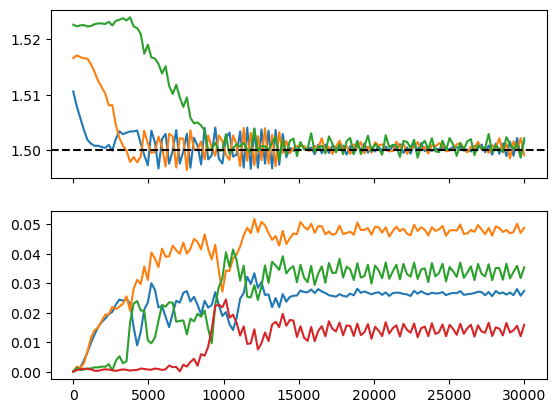

In [417]:
sim_old= pham.state.to_Simulation()
sim = rb.Simulation()
sim.add(m=sim_old.particles[0].m)
i=0
for p in sim_old.particles[1:]:
    sim.add(m=p.m,P = (1.5 * (1.005 + 0.002 * i))**(i))
    i+=1
pvars_new = cm.Poincare.from_Simulation(sim)

kam.state.values = ct.old_to_new_array(pvars_new.values)

tfin = 3e4
soln = solve_ivp(fn,(0,tfin),kam.state.values,t_eval=np.linspace(0,tfin,128),rtol = 1e-5)

for j,sol in enumerate(soln.y.T):
    pham.state.values = ct.new_to_old_array(sol)
    periods[j] = [p.P for p in pham.particles[1:]]
    eccs[j] = [p.e for p in pham.particles[1:]]


fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(soln.t,periods[:,1]/periods[:,0])
ax[0].plot(soln.t,periods[:,2]/periods[:,1])
ax[0].plot(soln.t,periods[:,3]/periods[:,2])
for j,e in enumerate(eccs.T):
    ax[1].plot(soln.t,e)
ax[0].axhline(1.5,color='k',ls='--')

In [421]:
kam.qp_vars

[φ₁, φ₂, ψ, h, y₁, y₂, y₃, y₄, v₁, v₂, v₃, v₄, \delta\Phi_{1}, \delta\Phi_{2}, \delta\Phi_{3}, \delta\Phi_{4}, x₁, x₂, x₃, x₄, u₁, u₂, u₃, u₄]

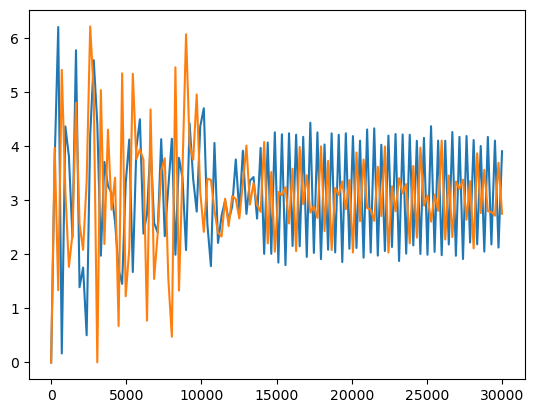

In [426]:
plt.plot(soln.t,np.mod(soln.y[0],2*np.pi))
plt.plot(soln.t,np.mod(soln.y[1],2*np.pi))

In [ ]:
kam_reduced = reduce_hamiltonian(kam)

tau_diss = sp.symbols("tau")
diss_terms = -1*sp.Matrix(kam_reduced.qp_vars)/tau_diss

diss_terms[0] = 0
diss_terms[1] = 0
diss_terms[kam_reduced.N_dof]=0
diss_terms[kam_reduced.N_dof+1]=0
fdiss = sp.lambdify(kam_reduced.qp_vars,diss_terms.xreplace({tau_diss:3e5}))

In [4]:
Npl = kam.N_dof//3

In [427]:
root_rule = {}
root_rule.update({kam.qp_vars[0]:np.pi})
root_rule.update({kam.qp_vars[1]:np.pi})
for i in range(Npl):
    root_rule.update({kam.qp_vars[Npl + i]:0})
    root_rule.update({kam.qp_vars[2*Npl + i]:0})
    # zero inlcination:
    root_rule.update({kam.qp_vars[kam.N_dof + 2 * Npl + i]:0})
root_rule.update({kam.qp_vars[kam.N_dof + Npl - 2]:0})
root_rule

{\delta\Phi_{3}: 0, φ₁: 3.141592653589793, φ₂: 3.141592653589793, u₁: 0, u₂: 0, u₃: 0, u₄: 0, v₁: 0, v₂: 0, v₃: 0, v₄: 0, y₁: 0, y₂: 0, y₃: 0, y₄: 0}

In [428]:
flow_i = np.concatenate((np.arange(Npl-2),np.arange(Npl,2*Npl)))
root_vars = [kam.qp_vars[i]  for i in  kam.N_dof + flow_i]
amd_var = kam.qp_vars[kam.N_dof + Npl-1]

In [429]:
Nvar = len(root_vars)

In [430]:
f = sp.Matrix([kam.N_flow[i].xreplace(root_rule) for i in flow_i])
Df = sp.Matrix(Nvar,Nvar,lambda i,j: sp.diff(f[i],root_vars[j]))

f_N = sp.lambdify(root_vars + [amd_var],f)
Df_N = sp.lambdify(root_vars + [amd_var],Df)

In [477]:
Npts = 50
x0 = np.zeros(Nvar)
solns = np.zeros((Npts,Nvar))
amds = np.linspace(-0.005,0.015,Npts)
for i,amd in enumerate(amds):
    rt_soln = root(
        lambda x,amd: f_N(*x,amd).reshape(-1),
        x0,
        args = (amd,),
        jac = lambda x,amd: Df_N(*x,amd)
    )
    x0 = rt_soln.x
    solns[i] = rt_soln.x

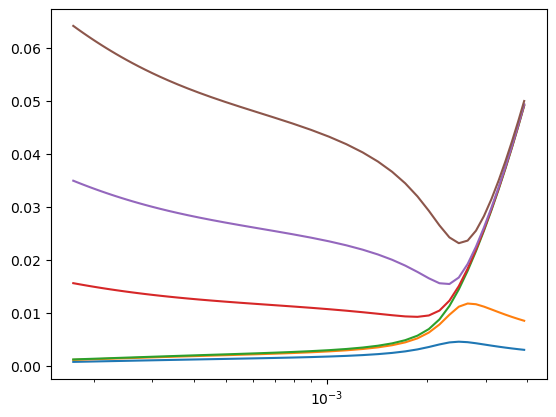

In [478]:
for var,val in root_rule.items():
    kam.qp[var] = val
periods,eccs = np.zeros((2,Npts,Npl))
j=0



jac = kam.calculate_jacobian()
freqs = np.zeros((Npts,len(i_active)),dtype = np.complex128)

for amd,soln in zip(amds,solns):
    kam.qp[amd_var] = amd
    for rv,val in zip(root_vars,soln):
        kam.qp[rv] = val
    
    flow = kam.calculate_flow()[i_active]
    assert np.alltrue(np.isclose(flow,0))
    jac = kam.calculate_jacobian()
    jac_reduced = np.array([[ jac[i,j] for j in i_active] for i in i_active])
    freqs[j] = np.linalg.eigvals(jac_reduced)
    pham.state.values = ct.new_to_old_array(kam.state.values)
    periods[j] = [p.P for p in pham.particles[1:]]
    eccs[j] = [p.e for p in pham.particles[1:]]
    j+=1

omega_sorted = np.sort(np.imag(freqs),axis=1)

plt.plot(2*Pratios[:,0]/3-1,omega_sorted[:,6:])
plt.xscale('log')

In [479]:
vals,vecs = np.linalg.eig(jac_reduced)

In [480]:
new_vars = np.linalg.inv(vecs) @ [kam.qp_vars[i] for i in i_active]

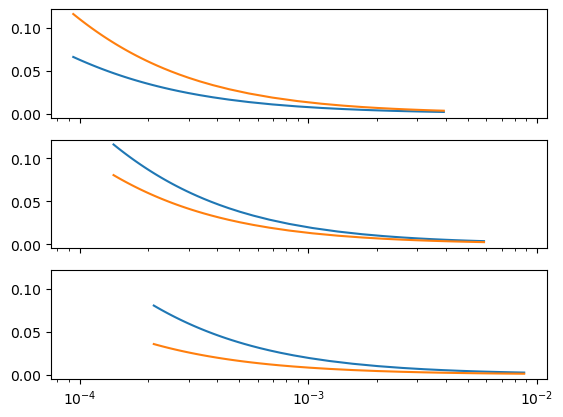

In [485]:
Pratios = periods[:,1:]/periods[:,:-1]
fig,ax = plt.subplots(3,1,sharex=True,sharey=True)
for j in range(3):
    ax[j].plot(Pratios[:,j]/1.5-1,eccs[:,j])
    ax[j].plot(Pratios[:,j]/1.5-1,eccs[:,j+1])
ax[j].set_xscale('log')